# COS20083 Advanced Data Analytics

## Assignment 2: Case Study and Algorithm Implementation

### Semester 1, 2021

#### Group Number: <p style ="color: green;">16</p>
#### Group Members: <p style ="color: green;">Thon Pun Liang, Joel Yeong Wai Hoe</p>

### <p style ="color: blue;">1. Introduction</p>

This assignment is focused on building a learning model to determine which newly launched property is worth investing in. The learning model is based on using real estate data scraped from a website of "Propsocial".  

The problem to be addressed by this case study is that there are many different prices and other factors for the property on sale. Learning models are built to help recommend property for property investors to buy.

### <p style ="color: blue;">2. Data Collection</p>

The purpose of web scraping in this case study is to efficiently comb through the web data of property listed for sale. In this way, the data can be efficiently go through the web data and get only the property and details requested.  

The process of web scraping starts with using Beautiful Soup. It is a tool for web scraping. By using python, the script is coded to request content from the website "propsocial.com". Next, the content is parsed to be structured data. Then, the details of pricing, location, furnishing and others are extracted by filtering through class names. Finally, when the function is created, the text data is saved into a csv file.

In [ ]:
import requests
from bs4 import BeautifulSoup
from io import StringIO
from html.parser import HTMLParser
import pandas as pd

# This class is mainly use to remove all the html tags in a string.
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.text = StringIO()

    def handle_data(self, d):
        self.text.write(d)

    def get_data(self):
        return self.text.getvalue()


def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()


headers = ({'User-Agent':
                'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})

n_pages = 0

# Initialise a new dataframe
df = pd.DataFrame(columns=['propertyName',
                           'pricing',
                           'tenure',
                           'propertyType',
                           'propertySQFT',
                           'furnishStatus',
                           'numBedroom',
                           'numBathroom'])

# Scrap a total of 1.5k pages
for page in range(0, 1500):
    n_pages += 1
    url = "https://www.propsocial.my/buy/kuala-lumpur-33?page=" + str(n_pages)  # The website that we are scraping out data from.

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    house_containers = soup.find_all('div', class_="classified-ad-details")

    if len(house_containers) != 0:
        for house in house_containers:
            if len(house.find_all('div')) >= 13:  # Check if each card is a property card (some are just advertisement).
                propertyName = (strip_tags(str(house.find_all('h3')[0]))).strip()
                pricing = (strip_tags(str(house.find_all('div', class_='pricing')[0]))).strip().replace('For Sale: RM ', '').replace(',', '')
                tenure = (strip_tags(str(house.find_all('div')[3]))).strip()
                propertyType = (strip_tags(str(house.find_all('div')[5]))).strip()
                propertySQFT = (strip_tags(str(house.find_all('div')[7]))).strip().replace(' SQ. FT', '').replace(',', '')
                furnishStatus = (strip_tags(str(house.find_all('div')[9]))).strip()
                numBedroom = (strip_tags(str(house.find_all('div')[11]))).strip().replace(' Bedrooms', '')
                numBathroom = (strip_tags(str(house.find_all('div')[13]))).strip().replace(' Bathrooms', '')

                # Create a dictionary for the property scraped.
                houseDetails = {'propertyName': propertyName,
                                'pricing': pricing,
                                'tenure': tenure,
                                'propertyType': propertyType,
                                'propertySQFT': propertySQFT,
                                'furnishStatus': furnishStatus,
                                'numBedroom': numBedroom,
                                'numBathroom': numBathroom}

                # Add the property details to the dataframe.
                df = df.append(houseDetails, ignore_index=True)

# Export dataframe to a csv file.
# This line is commented to avoid accidental run.
# df.to_csv('../data/propsocial_kl.csv', encoding='utf-8', index=False)

### <p style ="color: blue;">3. Exploratory Data Analysis</p>

Import necessary packages.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn library: Tools for machine learning and statistical modeling (https://scikit-learn.org/stable/)
from sklearn.preprocessing import scale, PolynomialFeatures
import sklearn.linear_model as skl_lm
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score, GridSearchCV

# Statsmodels: Tools for estimation of statistical models, statistical test and data exploration (http://www.statsmodels.org/)
import statsmodels.api as sm
import statsmodels.formula.api as smf

Exploratory data analysis (EDA) is used to analyze and investigate data sets and summarize their main characteristics, often employing data visualization methods. It helps determine how best to manipulate data sources to get the answers you need, making it easier to discover patterns, spot anomalies, test a hypothesis, or check assumptions.

First, import the dataset.  
Check the dataset's first 5 rows.

In [2]:
realEstateDF = pd.read_csv('../data/propsocial_kl.csv')  # Read CSV file into dataframe.
realEstateDF.head()  # Get and print the first 5 rows.

,propertyName,pricing,tenure,propertyType,propertySQFT,furnishStatus,numBedroom,numBathroom
0,"Taman Cheras Awana, Cheras",80000,Freehold,Apartment,507.0,Unfurnished,2,1
1,"The Elements, Ampang Hilir",800000,Freehold,Condominium,1572.0,Semi Furnished,4,3
2,"Tiffani Kiara, Mont Kiara",1230000,Freehold,Condominium,1641.0,Fully Furnished,4,3
3,"Kiaraville, Mont Kiara",2800000,Freehold,Condominium,3982.0,Semi Furnished,6,6
4,"Kenny Heights Estate, Kenny Heights",3700000,Freehold,Land,5230.0,Fully Furnished,0,0


In the main raw dataset we have many property types, ranging from a studio to a whole factory.  

The dataframe consists of 7 columns. Below shows the data dictionary:
propertyName: Name of the property
pricing: The asking sale price of the property
tenure: The tenure of the property, either Freehold or Leasehold
propertyType: Type of property
furnishStatus: Whether the property is furnished or not
numBedroom: Number of bedroom of the property
numBathroom: Number of bathroom of the property.

In this task, we will only look into Condominium.

In [3]:
condominium = realEstateDF.loc[realEstateDF['propertyType'] == "Condominium"]
del condominium['propertyType']
print("Rows     : ", condominium.shape[0])
print("Columns  : ", condominium.shape[1])
print("\nFeatures : \n", condominium.columns.tolist())
print("\nMissing values :  ", condominium.isnull().sum().values.sum())
print("\nUnique values :  \n", condominium.nunique())

Rows     :  11618
Columns  :  7

Features : 
 ['propertyName', 'pricing', 'tenure', 'propertySQFT', 'furnishStatus', 'numBedroom', 'numBathroom']

Missing values :   6

Unique values :  
 propertyName     1153
pricing          1692
tenure              2
propertySQFT     1641
furnishStatus       3
numBedroom         30
numBathroom        33
dtype: int64


We are left with 11,618 rows of data with missing values in 6 rows. We try to find and remove duplicate row.

In [4]:
# Remove duplicates from the dataset
condominium.duplicated(subset=None, keep="first")
print("Test", condominium.shape, "Train", condominium.shape)

# Get a summary of all features in the data and their types
condominium.info()

Test (11618, 7) Train (11618, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11618 entries, 1 to 22498
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   propertyName   11618 non-null  object 
 1   pricing        11618 non-null  object 
 2   tenure         11618 non-null  object 
 3   propertySQFT   11612 non-null  float64
 4   furnishStatus  11618 non-null  object 
 5   numBedroom     11618 non-null  object 
 6   numBathroom    11618 non-null  object 
dtypes: float64(1), object(6)
memory usage: 726.1+ KB


The number of rows did not change, meaning there are no duplicate rows.  
There are 6 missing data in the property built-up (propertySQFT) column. A built-up is an important factor that play a big role in affecting the property price. Thus, rows with null value in propertySQFT will be dropped.  
Besides, the Dtype for most of the columns are not correct as well.  

Next, we will perform some data cleaning.

In [5]:
# Changing attributes data type to the appropriate one
condominium['propertyName'] = condominium['propertyName'].astype('string')
condominium['tenure'] = condominium['tenure'].astype('string')
condominium['furnishStatus'] = condominium['furnishStatus'].astype('string')

condominium['pricing'] = condominium['pricing'].astype('string')
condominium['numBedroom'] = condominium['numBedroom'].astype('string')
condominium['numBathroom'] = condominium['numBathroom'].astype('string')

# Remove rows with null value in propertySQFT column
condominium = condominium[condominium['propertySQFT'].notna()]

# Format pricing to float
condominium['pricing'] = condominium['pricing'].str.replace('Auction \n            @ RM ','', True)
condominium['pricing'] = condominium['pricing'].astype('float')

# Remove white spaces from numBedroom and numBathroom
condominium['numBedroom'] = condominium['numBedroom'].str.replace(' ','', True)
condominium['numBathroom'] = condominium['numBathroom'].str.replace(' ','', True)

# Some rows contrains "N / A" & "n + n" where n is a number in column numBedroom & numBathroom
# Remove those rows by only taking numeric string
condominium = condominium[condominium['numBedroom'].str.isnumeric()]
condominium = condominium[condominium['numBathroom'].str.isnumeric()]
condominium['numBedroom'] = condominium['numBedroom'].astype('int')
condominium['numBathroom'] = condominium['numBathroom'].astype('int')

# Reset Index
condominium = condominium.reset_index(drop=True)

The describe() method is used for calculating some statistical data like percentile, mean and std of the numerical values of the Series or DataFrame. It analyzes both numeric and object series and also the DataFrame column sets of mixed data types.

In [6]:
condominium.describe()

,pricing,propertySQFT,numBedroom,numBathroom
count,9.555000e+03,9.555000e+03,9555.000000,9555.000000
mean,8.149063e+05,1.812555e+03,2.860283,2.211931
std,2.556645e+06,2.770492e+04,1.462191,1.409760
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,4.200000e+05,9.000000e+02,2.000000,2.000000
50%,5.490000e+05,1.076000e+03,3.000000,2.000000
75%,8.200000e+05,1.340000e+03,3.000000,2.000000
max,2.300000e+08,2.100000e+06,110.000000,110.000000


In [7]:
condominium.median()

pricing         549000.0
propertySQFT      1076.0
numBedroom           3.0
numBathroom          2.0
dtype: float64

From the table above, we can conclude:
- Mean of property sale price is RM 814906.
- Mean of property build-up is 1812.55 sqft.
- Mean of number of bedroom per property is 2.86. 
- Mean of number of bathroom per property is 2.21. 

The standard deviation is a measure of the amount of variation or dispersion of a set of values. A low standard deviation indicates that the values tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the values are spread out over a wider range.  
Median is the middle value of a sorted list of numbers. 

In [8]:
condominium.describe(include='string')

,propertyName,tenure,furnishStatus
count,9555,9555,9555
unique,1119,2,3
top,"Nusa Mewah, Cheras",Freehold,Semi Furnished
freq,208,8478,4570


Some of the properties are repeated, however, the repeated often have different sale price and different attributes. This is logical as in a condominium there are many unit typesm ranging from studio to penthouse. Therefore, these rows are not merged into 1.

In [9]:
condominium.head()

,propertyName,pricing,tenure,propertySQFT,furnishStatus,numBedroom,numBathroom
0,"The Elements, Ampang Hilir",800000.0,Freehold,1572.0,Semi Furnished,4,3
1,"Tiffani Kiara, Mont Kiara",1230000.0,Freehold,1641.0,Fully Furnished,4,3
2,"Kiaraville, Mont Kiara",2800000.0,Freehold,3982.0,Semi Furnished,6,6
3,"Sunway Mont Residences, Mont Kiara",1000000.0,Freehold,1122.0,Semi Furnished,3,2
4,"Pavilion Hilltop, Mont Kiara",1650000.0,Freehold,1496.0,Fully Furnished,3,3


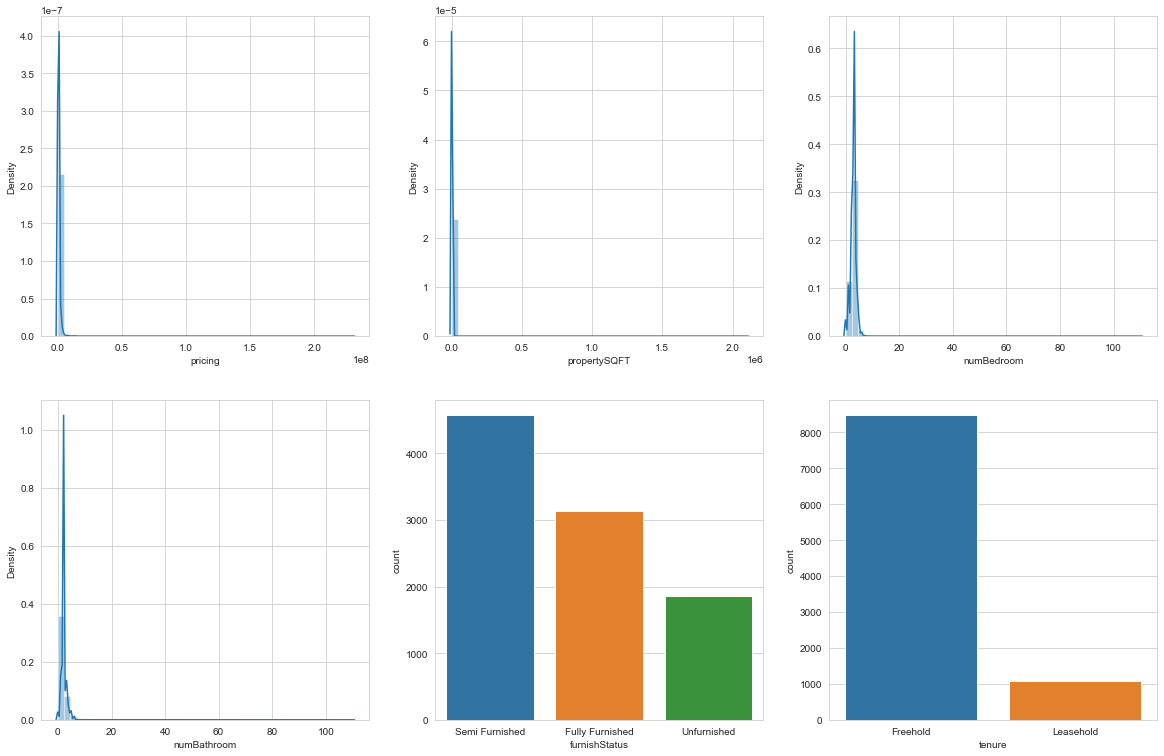

In [10]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 4)
sns.distplot(condominium['pricing']);
plt.subplot(3, 3, 5)
sns.distplot(condominium['propertySQFT']);
plt.subplot(3, 3, 6)
sns.distplot(condominium['numBedroom']);
plt.subplot(3, 3, 7)
sns.distplot(condominium['numBathroom']);
plt.subplot(3, 3, 8)
sns.countplot(data=condominium, x='furnishStatus');
plt.subplot(3, 3, 9)
sns.countplot(data=condominium, x='tenure');

condominium['furnishStatus'] = condominium.furnishStatus.factorize()[0]
condominium['tenure'] = condominium.tenure.factorize()[0]

# Reset Index
condominium = condominium.reset_index(drop=True)

# Generate Index column
condominium['id'] = condominium.index

From the charts above, it is noticed that the attributes pricing, propertySQFT, numBedroom, numBathroom are heavily skewed to the left due to outliers. We will remove the outliers by removing rows with Z-score of column value greater than 3. For each column, we first compute the Z-score of each value in the column, relative to the column mean and standard deviation. We then take the absolute Z-score because the direction does not matter, only if it is below the threshold.  
A Z score of 3 refers to 3 standard deviations. That would mean that more than 99% of the population was covered by the z score. A data point can be considered unusual if its z-score is above 3 or below −3 .

In [11]:
# Removing outliers
condominium = condominium[(np.abs(stats.zscore(condominium['pricing'])) < 3)]
condominium = condominium[(np.abs(stats.zscore(condominium['propertySQFT'])) < 3)]
condominium = condominium[(np.abs(stats.zscore(condominium['numBedroom'])) < 3)]
condominium = condominium[(np.abs(stats.zscore(condominium['numBathroom'])) < 3)]

<AxesSubplot:xlabel='propertySQFT', ylabel='pricing'>

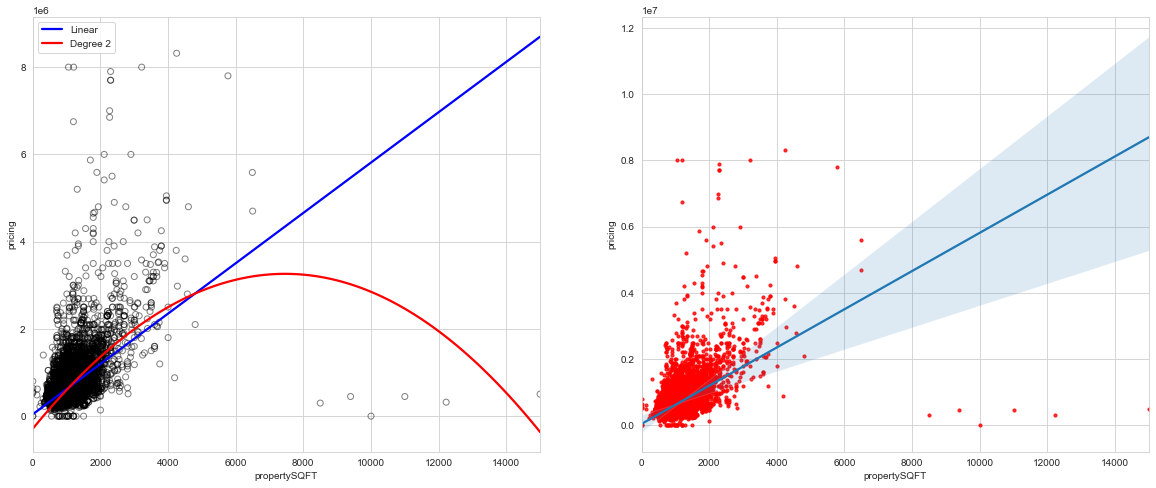

In [12]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)

plt.scatter(condominium.propertySQFT, condominium.pricing, facecolors='None', edgecolors='k', alpha=.5) 
sns.regplot(condominium.propertySQFT, condominium.pricing, ci=None, label='Linear', scatter=False, color='b')
sns.regplot(condominium.propertySQFT, condominium.pricing, ci=None, label='Degree 2', order=2, scatter=False, color='r')
plt.legend()

plt.subplot(1, 2, 2)
sns.regplot(condominium.propertySQFT, condominium.pricing, order=1, ci=100, scatter_kws={'color':'r', 's':10})

We can still see the drawing of the red regression line is very weird due to outliers. We will manually remove these outliers.

In [13]:
# Removing outliers
condominium = condominium[condominium.propertySQFT < 8000]
condominium = condominium[condominium.pricing < 6000000]
condominium = condominium[condominium.propertySQFT > 0]
condominium = condominium[condominium.pricing > 0]

<AxesSubplot:xlabel='propertySQFT', ylabel='pricing'>

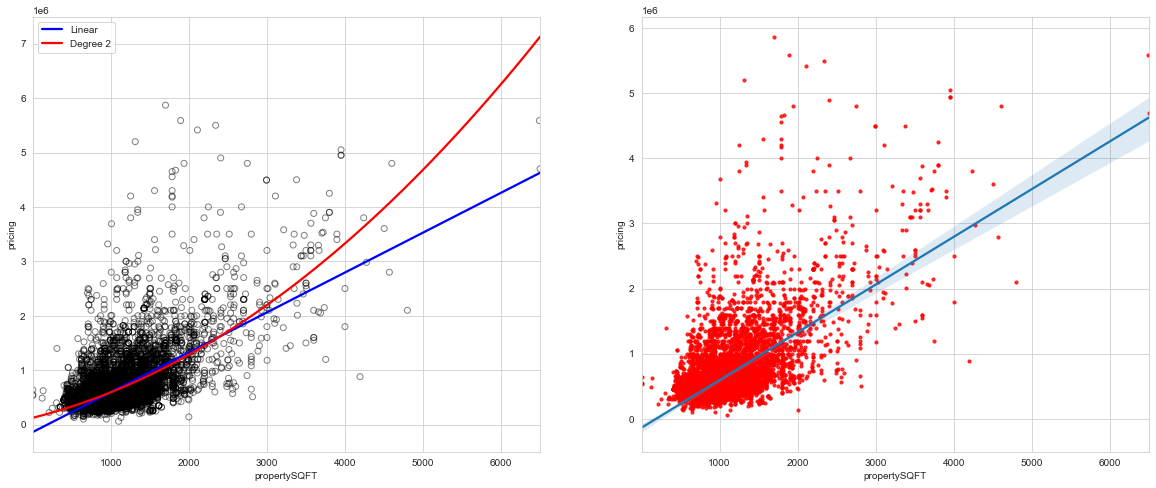

In [14]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)

plt.scatter(condominium.propertySQFT, condominium.pricing, facecolors='None', edgecolors='k', alpha=.5) 
sns.regplot(condominium.propertySQFT, condominium.pricing, ci=None, label='Linear', scatter=False, color='b')
sns.regplot(condominium.propertySQFT, condominium.pricing, ci=None, label='Degree 2', order=2, scatter=False, color='r')
plt.legend()

plt.subplot(1, 2, 2)
sns.regplot(condominium.propertySQFT, condominium.pricing, order=1, ci=100, scatter_kws={'color':'r', 's':10})

Now we plot the distribution charts gain to see the changes.

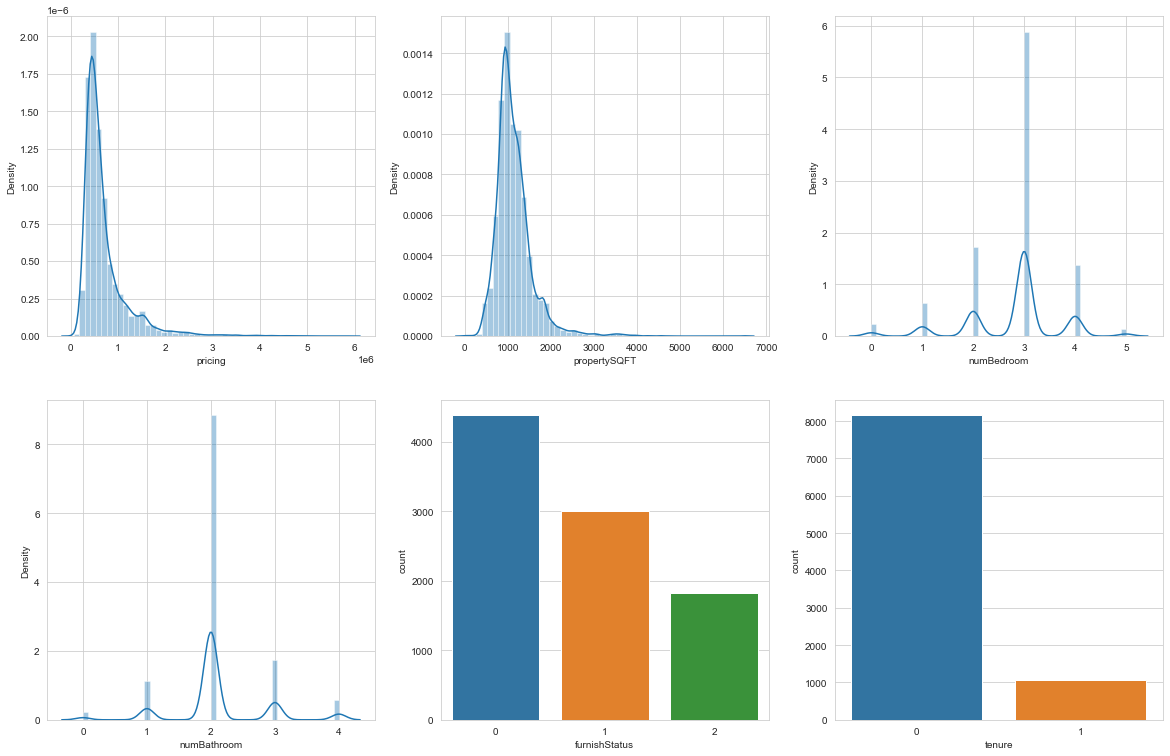

In [15]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 4)
sns.distplot(condominium['pricing']);
plt.subplot(3, 3, 5)
sns.distplot(condominium['propertySQFT']);
plt.subplot(3, 3, 6)
sns.distplot(condominium['numBedroom']);
plt.subplot(3, 3, 7)
sns.distplot(condominium['numBathroom']);
plt.subplot(3, 3, 8)
sns.countplot(data=condominium, x='furnishStatus');
plt.subplot(3, 3, 9)
sns.countplot(data=condominium, x='tenure');

condominium['furnishStatus'] = condominium.furnishStatus.factorize()[0]
condominium['tenure'] = condominium.tenure.factorize()[0]

# Reset Index
condominium = condominium.reset_index(drop=True)

# Generate Index column
condominium['id'] = condominium.index

From the pricing chart, the distribution of sale prices is right skewed, something that is expected. 

Plotting a correlation matrix to shows a brief idea of relationships that exist in the data. 

In [16]:
corr = condominium.corr()
corr.style.background_gradient(cmap='coolwarm')

,pricing,tenure,propertySQFT,furnishStatus,numBedroom,numBathroom,id
pricing,1.000000,-0.066921,0.621985,-0.034078,0.048219,0.332396,0.025454
tenure,-0.066921,1.000000,-0.026947,0.091752,0.071005,0.008881,0.088166
propertySQFT,0.621985,-0.026947,1.000000,-0.065583,0.486317,0.596177,-0.008513
furnishStatus,-0.034078,0.091752,-0.065583,1.000000,-0.110034,-0.094558,-0.011768
numBedroom,0.048219,0.071005,0.486317,-0.110034,1.000000,0.673081,-0.006040
numBathroom,0.332396,0.008881,0.596177,-0.094558,0.673081,1.000000,-0.037508
id,0.025454,0.088166,-0.008513,-0.011768,-0.006040,-0.037508,1.000000


<AxesSubplot:>

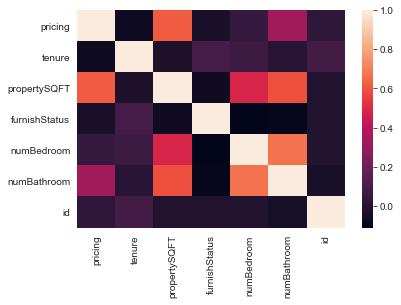

In [17]:
sns.heatmap(corr)

The correlation measure used here is Pearson's correlation. The ligher the square the the stronger the correlation between two variables.  
Features related to space such as property sqft, number of bedroom and number of bathroom seems positively correlated with the sales price as expected. The logic being that larger properties should be more expensive.  
Features such as tenure and furnish status does not seem to be related with the pricing.

We will plot some joint histogram and scatter grphs to look at correlated features in more detail

<Figure size 720x720 with 0 Axes>

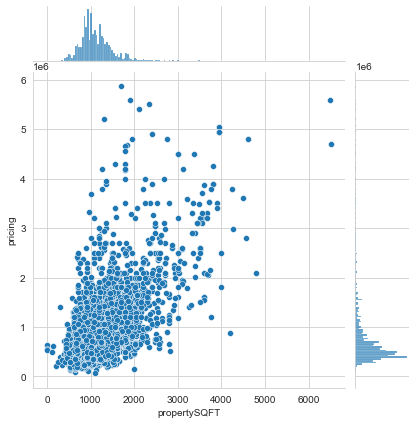

<Figure size 720x720 with 0 Axes>

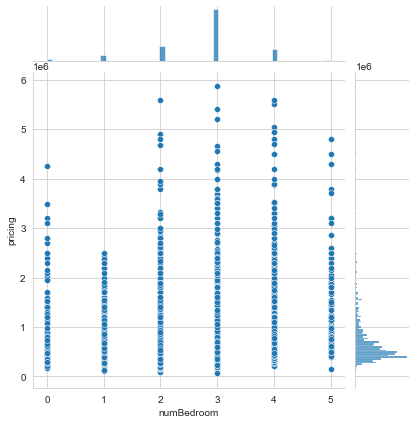

<Figure size 720x720 with 0 Axes>

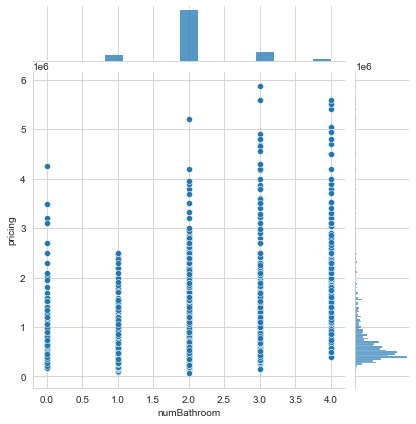

In [18]:
y = condominium.pricing
features = [
    "propertySQFT",
    "numBedroom",
    "numBathroom"
]

for features in features:
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 10))
    x = condominium[features]
    sns.jointplot(x=x, y=y, data=condominium)

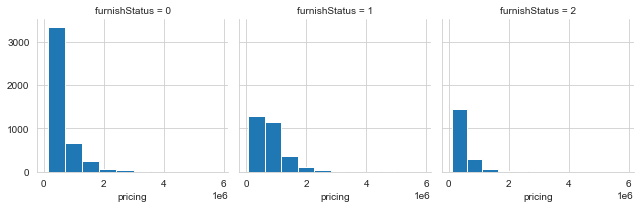

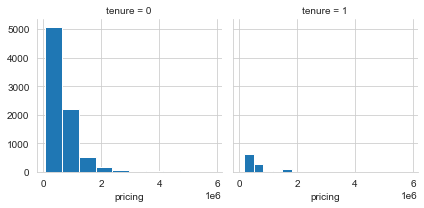

In [19]:
features = [
    "furnishStatus",
    "tenure"
]

for features in features:
    g = sns.FacetGrid(condominium, col=features)
    g.map(plt.hist, 'pricing');

We can also plot some boxplots of pricing against each attribute.

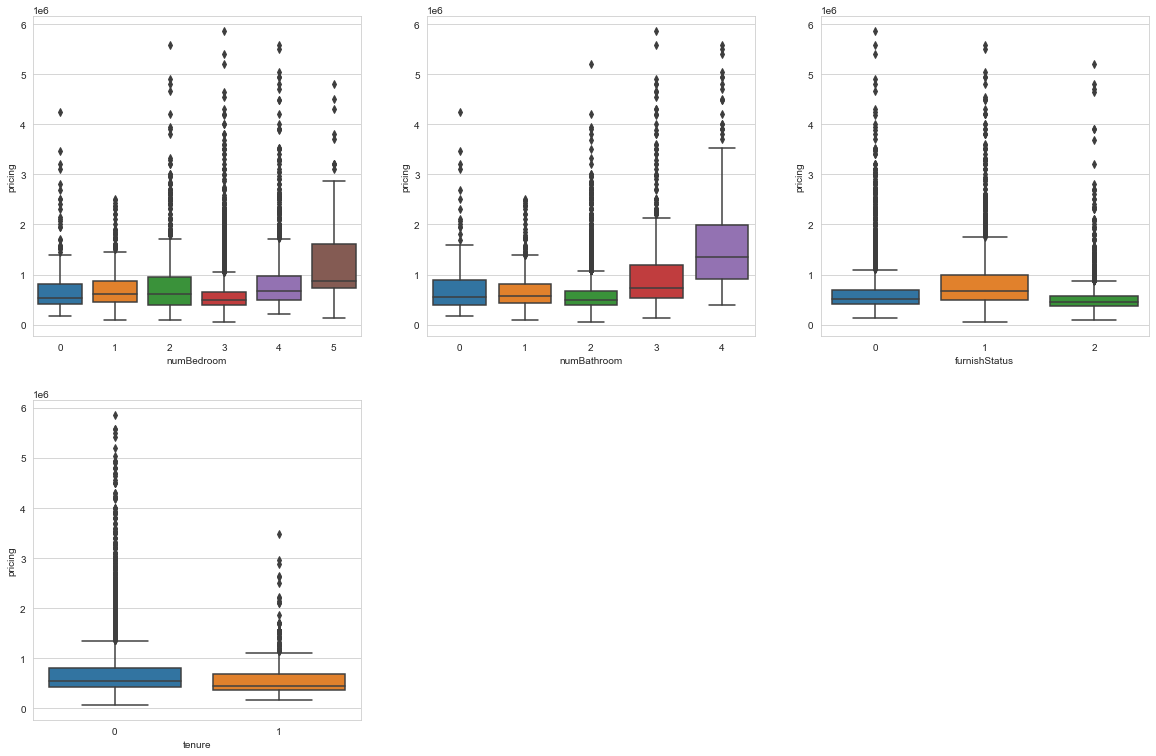

In [20]:
plt.figure(figsize = (20, 20))
plt.subplot(3, 3, 1)
sns.boxplot(y="pricing", x= "numBedroom", data=condominium,  orient='v')
plt.ylabel('pricing')
plt.xlabel('numBedroom')
plt.subplot(3, 3, 2)
sns.boxplot(y="pricing", x= "numBathroom", data=condominium,  orient='v')
plt.ylabel('pricing')
plt.xlabel('numBathroom')
plt.subplot(3, 3, 3)
sns.boxplot(y="pricing", x= "furnishStatus", data=condominium,  orient='v')
plt.ylabel('pricing')
plt.xlabel('furnishStatus')
plt.subplot(3, 3, 4)
sns.boxplot(y="pricing", x= "tenure", data=condominium,  orient='v')
plt.ylabel('pricing')
plt.xlabel('tenure')
plt.show()

### <p style ="color: blue;">4. Model Building</p>

The task is supervised machine learning, regression task. The aim is to predict a property sale price, then the predicted price is compared to the actual to see if the property is worth investing.  
In this section, we will train several ML models with the goal of finding the best model that fits our data, especially the test datasets.

Process of model building here:
- Convert categorical attributes into numeric value
- Separate dataset at 75% of training set and 25% of testing set.
- Separate predictors and labels of training set and testing set.
- Fit the training set into selected model

We will take all attributes as our predictors as later in the model building we will use hyperparameter optimization to find the best performance model.

In [21]:
condominium.shape[0]

9224

In [22]:
# Converting categorical columns to numeric value
condominium['furnishStatus'] = condominium.furnishStatus.factorize()[0]
condominium['tenure'] = condominium.tenure.factorize()[0]

# Separate dataframe into train set and test set. 75% for train, 25% for test
# 75% of 9224 is 6918
train_df = condominium.iloc[:6918, :]
test_df = condominium.iloc[6918:, :]

# Sepatate predictors and labels.
X_train = train_df[['propertySQFT', 'numBedroom', 'numBathroom', 'tenure', 'furnishStatus']].values
y_train = train_df.pricing

X_test = test_df[['propertySQFT', 'numBedroom', 'numBathroom', 'tenure', 'furnishStatus']].values
y_test = test_df.pricing

#### Linear Regression, Decision Trees, Random Forest

Import necessary model from sklearn library and fit our training data into the model.

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Using DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

# Using RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Let's compute some results first from each model by using our testing set to select the best model.

In [24]:
from sklearn.metrics import mean_squared_error, r2_score

lin_predictions = lin_reg.predict(X_test) 
lin_mse = mean_squared_error(y_test, lin_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_r2 = r2_score(y_test, lin_predictions)

tree_predictions = tree_reg.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_r2 = r2_score(y_test, tree_predictions)

forest_predictions = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_test, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_r2 = r2_score(y_test, forest_predictions)

print("Root Mean-Squared Error:")
print("LinearRegression       :", lin_rmse)
print("DecisionTreeRegressor  :", tree_rmse)
print("RandomForestRegressor  :", forest_rmse)

print("\nR-squared Score:")
print("LinearRegression       :", lin_r2)
print("DecisionTreeRegressor  :", tree_r2)
print("RandomForestRegressor  :", forest_r2)

Root Mean-Squared Error:
LinearRegression       : 364789.4114801627
DecisionTreeRegressor  : 389237.84968374297
RandomForestRegressor  : 333923.68443630746

R-squared Score:
LinearRegression       : 0.5010573193459407
DecisionTreeRegressor  : 0.4319372162715298
RandomForestRegressor  : 0.5819187838850663


The RMSE tells us that the models have typical prediction error of the value.  
For example, from the RMSE of the RandomForestRegressor model, it means that our model is off by around RM 333,924 in predicting a property price.  
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.  The higher the R-squared value, the better the model.
The RMSE of the RandomForestRegressor is the lowest among all, the R2 score of the RandomForestRegressor is the highest among all, which suggests that the model performs the best among the three. Therefore we will fine tune our Random Forest model using randomised search technique.  
Random search technique will evaluate all the possible combination of hyper parameters values, using cross validation.

#### Grid Search - Fine Tune Random Forest Model

In [25]:
# Using grid search to fine tune the model. Random forest
from sklearn.model_selection import GridSearchCV

# Randomized hyper parameter search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {
        'n_estimators': randint(low=1, high=150),
        'max_features': randint(low=1, high=5),
    }
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

352412.94434211456 {'max_features': 3, 'n_estimators': 93}
352509.68410511623 {'max_features': 3, 'n_estimators': 107}
355322.31598256883 {'max_features': 4, 'n_estimators': 21}
352636.0839621247 {'max_features': 3, 'n_estimators': 122}
352373.38448328146 {'max_features': 3, 'n_estimators': 75}
352267.3267043313 {'max_features': 3, 'n_estimators': 88}
361247.42713705497 {'max_features': 1, 'n_estimators': 100}
351780.91849919566 {'max_features': 4, 'n_estimators': 131}
358838.26530371007 {'max_features': 2, 'n_estimators': 53}
357470.3167597109 {'max_features': 2, 'n_estimators': 88}


We see that combination of 4 feature and 131 estimators gives the lowest RMSE of RM 351,780.

In [26]:
# Feature Importance
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances
sorted(zip(feature_importances, ['propertySQFT', 'numBedroom', 'numBathroom', 'tenure', 'furnishStatus']), reverse=True)

[(0.7692475064717806, 'propertySQFT'),
 (0.09635131752549346, 'numBedroom'),
 (0.07282963039275812, 'numBathroom'),
 (0.0482056663622918, 'furnishStatus'),
 (0.013365879247675846, 'tenure')]

This step allows us to understand which feature are most important and which are of low importance, i.e candidate that can be dropped. As we seen earlier, propertySQFT is top feature for the model, which is logical.

### <p style ="color: blue;">5. Model Evaluation</p>

From the random search above we get the best estimator and test it with out test set.  
We then compute the RMSE and R2 score.

In [27]:
# Get the best model from the random search
final_model = rnd_search.best_estimator_
final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, final_predictions)

print("RandomForestRegressor")
print("Root Mean-Squared Error  :", final_rmse)
print("R-squared Score          :", final_r2)

RandomForestRegressor
Root Mean-Squared Error  : 337268.3347215702
R-squared Score          : 0.5735016602357321


In [28]:
# Computing 95% confidence interval
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([294432.89480136, 375245.42591565])

At the end we get the RMSE of RM 337,268 from our random forest model.  
From the prediction interval of model we can tell how much the error can fluctuate.  
From the result above, the prediction error can fluctuate anywhere between RM 294,432 to RM 375,245.  

The model can be used to predict the future value of a proptery by comparing the model's predicted sale price and the actual price of the property. If the actual > the predicted, it means that the property is more likely not worth investing and vice versa. 

### <p style ="color: blue;">6. Model Validation (Challenge)</p>

For the model validation, we will use cross validation from the sklearn library, and we will create a different set of training and testing set to test our model.  
The scores are then compared with the scores we had previously.

In [29]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [30]:
scores = cross_val_score(final_model, X_test, y_test,
                         scoring="neg_mean_squared_error", cv=10)  # 10 folds
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [225116.58343488 377065.10200571 279631.28854008 447683.5625907
 334246.04229706 382945.32000483 262356.41804982 326274.61437384
 343864.3835622  365031.700147  ]
Mean: 334421.5015006114
Standard deviation: 61835.908459097336


We can see that there is not much different between the Mean value.  
Now we try creating another set of training and testing set to test our model.  
We will inverse the main dataframe and do the spliting 

In [31]:
condominium.head()

,propertyName,pricing,tenure,propertySQFT,furnishStatus,numBedroom,numBathroom,id
0,"The Elements, Ampang Hilir",800000.0,0,1572.0,0,4,3,0
1,"Tiffani Kiara, Mont Kiara",1230000.0,0,1641.0,1,4,3,1
2,"Sunway Mont Residences, Mont Kiara",1000000.0,0,1122.0,0,3,2,2
3,"Pavilion Hilltop, Mont Kiara",1650000.0,0,1496.0,1,3,3,3
4,"Sentul Utama Condominium, Sentul",330000.0,0,853.0,0,3,2,4


In [32]:
condominium = condominium.iloc[::-1]
condominium.tail()

,propertyName,pricing,tenure,propertySQFT,furnishStatus,numBedroom,numBathroom,id
4,"Sentul Utama Condominium, Sentul",330000.0,0,853.0,0,3,2,4
3,"Pavilion Hilltop, Mont Kiara",1650000.0,0,1496.0,1,3,3,3
2,"Sunway Mont Residences, Mont Kiara",1000000.0,0,1122.0,0,3,2,2
1,"Tiffani Kiara, Mont Kiara",1230000.0,0,1641.0,1,4,3,1
0,"The Elements, Ampang Hilir",800000.0,0,1572.0,0,4,3,0


We noticed that after we inversed the dataset, the head of the old and the tail of the new dataframe is the same. This means that we had successfully reversed the dataset and is good for spliting it into train and test set.

In [33]:
# Separate dataframe into train set and test set. 75% for train, 25% for test
# 75% of 9224 is 6918
train_df = condominium.iloc[:6918, :]
test_df = condominium.iloc[6918:, :]
X_train = train_df[['propertySQFT', 'numBedroom', 'numBathroom', 'tenure', 'furnishStatus']].values
y_train = train_df.pricing
X_test = test_df[['propertySQFT', 'numBedroom', 'numBathroom', 'tenure', 'furnishStatus']].values
y_test = test_df.pricing

# Compute scores
final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, final_predictions)

print("RandomForestRegressor")
print("Root Mean-Squared Error  :", final_rmse)
print("R-squared Score          :", final_r2)

RandomForestRegressor
Root Mean-Squared Error  : 165228.04814094063
R-squared Score          : 0.8847520554512207


We achieved a much lower RMSE and higher R2 score which is reasonable as the testing set is used as a training set to train the model previously.

### <p style ="color: blue;">7. Discussion</p>

In [34]:
# At this cell we find the best property (Condominium) in KL to invest.
temp = condominium[['propertySQFT', 'numBedroom', 'numBathroom', 'tenure', 'furnishStatus']]
main = condominium
main['pred'] = final_model.predict(temp)
main['resid'] = main.pricing - main.pred

# The lower the residual, meaning the actual price is lower than the predicted price, the proptery is more worthy to invest in.
main = main.sort_values(by='resid')
main.head()

,propertyName,pricing,tenure,propertySQFT,furnishStatus,numBedroom,numBathroom,id,pred,resid
7875,"Laman Residen, Jalan Ipoh",1800000.0,0,4000.0,0,5,4,7875,3.967185e+06,-2.167185e+06
7114,"Sri Putramas II, Dutamas",980000.0,0,2340.0,1,5,4,7114,2.756740e+06,-1.776740e+06
8640,"Platinum Lake PV13, Setapak",450000.0,0,1313.0,2,3,1,8640,2.085262e+06,-1.635262e+06
202,"KL Palace Court, Kuchai Lama",530000.0,0,1313.0,2,3,2,202,2.152219e+06,-1.622219e+06
456,"KL Palace Court, Kuchai Lama",530000.0,0,1313.0,2,3,2,456,2.152219e+06,-1.622219e+06


The lower the residual, meaning the actual price is lower than the predicted price, the property is more worth to invest in.  
The property <strong>Laman Presiden, Jalan Ipoh</strong> is selling at RM 1,800,000. The predicted price for the same property is RM 3,967,185. The predicted is > than the actual price, which means the property is worth investing.  

The main limitation of random forest is that a large number of trees can make the algorithm too slow and ineffective for real-time predictions. Also, it surely does a good job at classification but not as for regression problem as it does not gives precise continuous nature prediction. In case of regression, it doesn't predict beyond the range in the training data, and that they may over fit data sets that are particularly noisy.  

We would like to take a chance to mention that the main limitation of the model produced is that it takes in only a few attributes as the predictors (5 only). There are more predictors that could affect the performance of the model such as facilities at the residence, neighborhood amenities, and the property price trend from recent transactions.  
Unfortunately, we could not successfully get those data during our web scraping process.